In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from simplefwi.misfit import MisfitFunction, DataMisfit, RegMisfit
from simplefwi.optimization import BBiter, CGiter
from simplefwi.core import ForwardSolver, getA, getP
from scipy.sparse import linalg
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat

In [2]:
f = loadmat('data/marmousi_50.mat')
vel = f['vel']

# smooth velocity model
vel0 = gaussian_filter(vel, sigma=5)

In [3]:
# spatial axes
dx, dz = 50, 50
h = np.array([dz, dx]) # z, x
n = np.array(vel.shape) # z, x

z = np.arange(0, n[0]) * dz
x = np.arange(0, n[1]) * dx

# frequencies
f = np.array([1.0, 2.0, 3.0])

# sources position
xs = np.arange(dx, n[1]*dx, 5 * dx)
zs = 4 * dx * np.ones_like(xs)

# receivers position
xr = np.arange(dx, n[1]*dx, 3 * dx)
zr = 2 * dx * np.ones_like(xr)

# sources matrix
q = np.eye(len(xs))

In [4]:
model = {
    'h': h,
    'f': f,
    'xr': xr,
    'zr': zr,
    'xs': xs,
    'zs': zs,
    'n': n,
    'z': z,
    'x': x,
    'q': q,
}

In [5]:
m, m0 = 1./(vel.reshape(-1, 1)) ** 2, 1./(vel0.reshape(-1, 1)) ** 2

/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_r],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

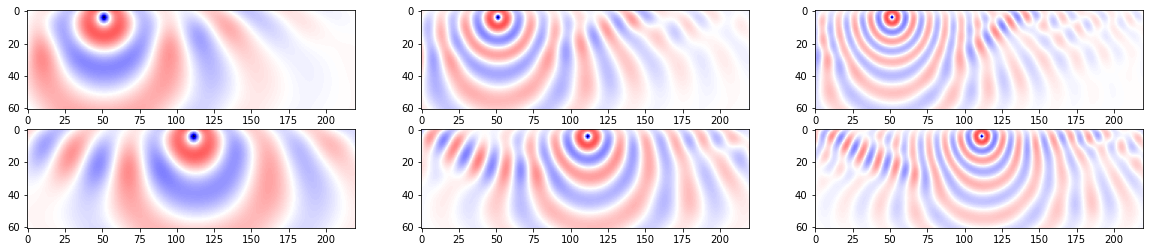

In [6]:
Fm = ForwardSolver(model)
U, _ = Fm.solve(m0, rsample=False)

clip = 1e3

fig, axs = plt.subplots(2, 3, figsize=(20, 4))
axs[0][0].imshow(np.real(U[:, 10, 0]).reshape(n), cmap='seismic', vmin=-clip, vmax=clip)
axs[0][0].axis('tight')
axs[0][1].imshow(np.real(U[:, 10, 1]).reshape(n), cmap='seismic', vmin=-clip, vmax=clip)
axs[0][1].axis('tight')
axs[0][2].imshow(np.real(U[:, 10, 2]).reshape(n), cmap='seismic', vmin=-clip, vmax=clip)
axs[0][2].axis('tight')
axs[1][0].imshow(np.real(U[:, len(zs)//2, 0]).reshape(n), cmap='seismic', vmin=-clip, vmax=clip)
axs[1][0].axis('tight')
axs[1][1].imshow(np.real(U[:, len(zs)//2, 1]).reshape(n), cmap='seismic', vmin=-clip, vmax=clip)
axs[1][1].axis('tight')
axs[1][2].imshow(np.real(U[:, len(zs)//2, 2]).reshape(n), cmap='seismic', vmin=-clip, vmax=clip)
axs[1][2].axis('tight');

(-0.5, 219.5, 60.5, -0.5)

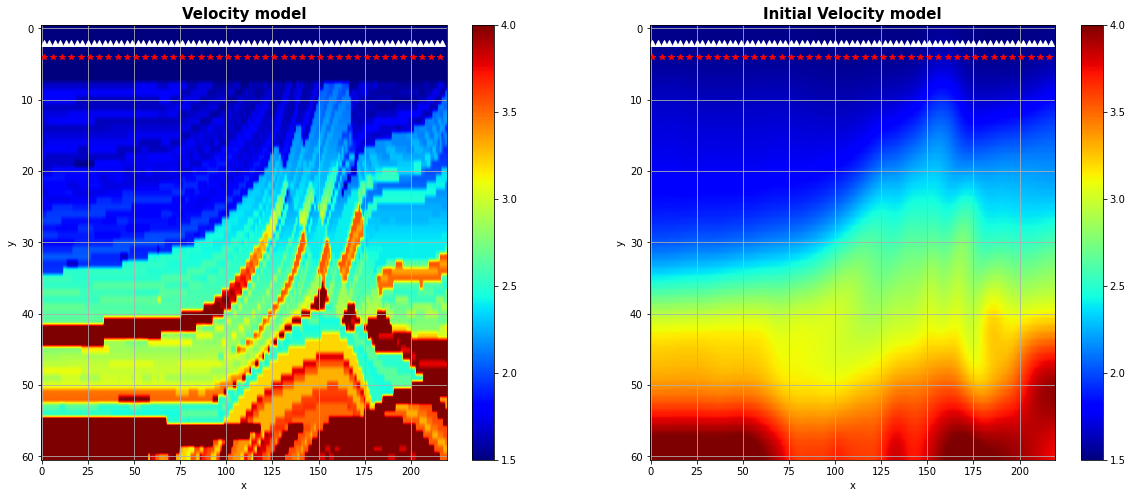

In [7]:
# plot model
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(1./np.sqrt(m).reshape(n), vmin=1.5, vmax=4, cmap='jet')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(1./np.sqrt(m0).reshape(n), vmin=1.5, vmax=4, cmap='jet')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

In [8]:
Fm = ForwardSolver(model)
Dobs, Jo = Fm.solve(m)
dataMisfit = DataMisfit(Dobs, model)
regMisfit = RegMisfit(n, alpha=0.5, m0=m0)
misfitFn = MisfitFunction(dataMisfit, regMisfit)

/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_r],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

In [9]:
history, mk, gk = BBiter(misfitFn, m0, tol=1.e-3, maxit=20, bounds=(0.045, 0.45))

Optimization starts!
k: 1  fk: 6922584.06  ||gk||: 9497619.95
k: 2  fk: 4012857.43  ||gk||: 5854014.36
k: 3  fk: 2382871.54  ||gk||: 4819521.75
k: 4  fk: 2549998.32  ||gk||: 9606466.23
k: 5  fk: 1934089.28  ||gk||: 7681386.63
k: 6  fk: 1100695.08  ||gk||: 1818926.70
k: 7  fk: 1013793.73  ||gk||: 1676210.41
k: 8  fk: 466466.09  ||gk||: 928384.47
k: 9  fk: 281847.45  ||gk||: 2168825.12
k: 10  fk: 5318778.88  ||gk||: 18952446.44
k: 11  fk: 4164798.00  ||gk||: 16312733.27
k: 12  fk: 202384.68  ||gk||: 1039267.20
k: 13  fk: 176563.64  ||gk||: 777850.85
k: 14  fk: 137027.84  ||gk||: 485677.23
k: 15  fk: 111946.69  ||gk||: 615373.24
k: 16  fk: 292885.20  ||gk||: 3945256.20
k: 17  fk: 125260.91  ||gk||: 1783426.07
k: 18  fk: 83946.42  ||gk||: 269819.08
k: 19  fk: 82160.76  ||gk||: 247949.68
k: 20  fk: 70130.67  ||gk||: 265860.13
Optimization ended!


(0.04999999999999993, 20.95, 0.0077789178222803165, 2.598789056546699)

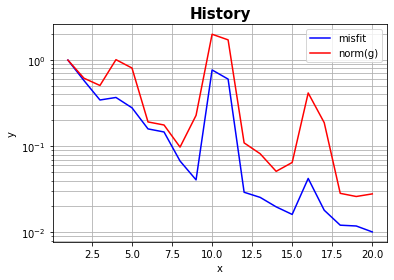

In [10]:
plt.figure()
plt.semilogy(history[:, 0], history[:, 1] / history[0, 1], "b-", label='misfit')
plt.semilogy(history[:, 0], history[:, 2] / history[0, 2], "r-", label='norm(g)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('History', fontsize=15, fontweight='bold')
plt.legend()
plt.grid('on', which='both')
plt.axis('tight')

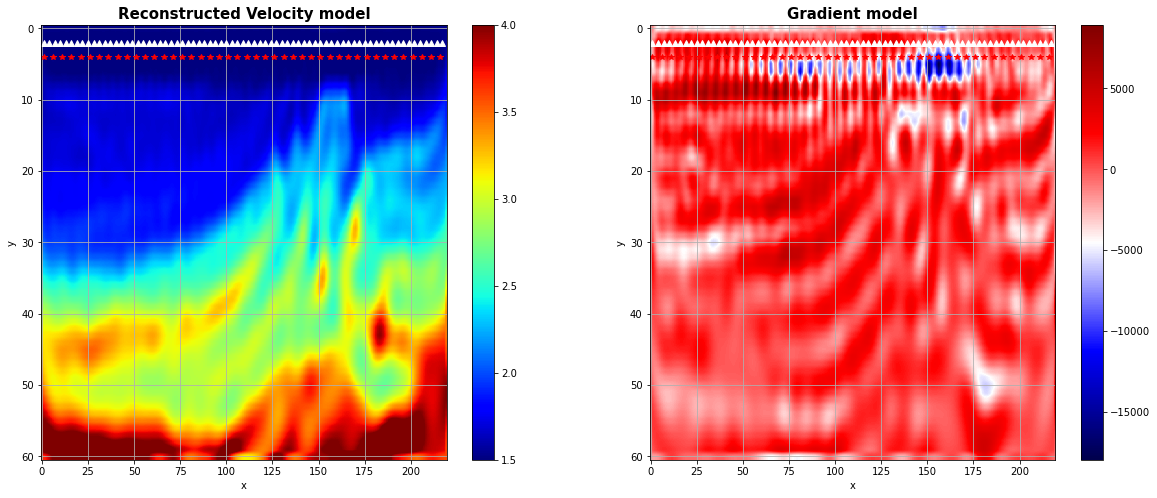

In [11]:
# plot model
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(1./np.sqrt(mk).reshape(n), vmin=1.5, vmax=4, cmap='jet')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reconstructed Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(gk.reshape(n), cmap='seismic')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight');

In [12]:
history, mk, gk = CGiter(misfitFn, m0, Dobs, Fm, tol=1.e-3, maxit=20, bounds=(0.045, 0.45))

/Users/ravasim/opt/anaconda3/envs/pylops/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

Optimization starts!
k: 1  fk: 8816272.94  ||gk||: 13641211.40
k: 2  fk: 4806301.74  ||gk||: 6980100.75
k: 3  fk: 2271046.20  ||gk||: 4189898.60
k: 4  fk: 1401828.04  ||gk||: 3585530.39
k: 5  fk: 891290.21  ||gk||: 2452072.97
k: 6  fk: 569841.94  ||gk||: 1679409.26
k: 7  fk: 394282.05  ||gk||: 1819287.94
k: 8  fk: 268670.21  ||gk||: 1107686.52
k: 9  fk: 186651.84  ||gk||: 983639.45
k: 10  fk: 148473.19  ||gk||: 716536.33
k: 11  fk: 119464.01  ||gk||: 654681.29
k: 12  fk: 97484.75  ||gk||: 625085.30
k: 13  fk: 72459.45  ||gk||: 604223.02
k: 14  fk: 58741.21  ||gk||: 388931.29
k: 15  fk: 49658.75  ||gk||: 361874.05
k: 16  fk: 43959.88  ||gk||: 273955.82
k: 17  fk: 37566.48  ||gk||: 291356.92
k: 18  fk: 32729.91  ||gk||: 237443.04
k: 19  fk: 29191.63  ||gk||: 277474.14
k: 20  fk: 26083.20  ||gk||: 195366.22
Optimization ended!


(0.04999999999999993, 20.95, 0.002211207902318399, 1.337969491068037)

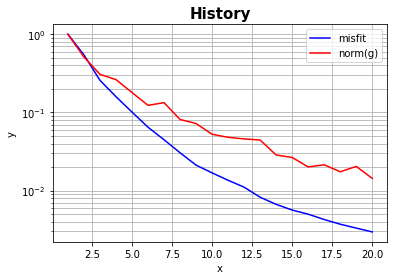

In [13]:
plt.figure()
plt.semilogy(history[:, 0], history[:, 1] / history[0, 1], "b-", label='misfit')
plt.semilogy(history[:, 0], history[:, 2] / history[0, 2], "r-", label='norm(g)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('History', fontsize=15, fontweight='bold')
plt.legend()
plt.grid('on', which='both')
plt.axis('tight')

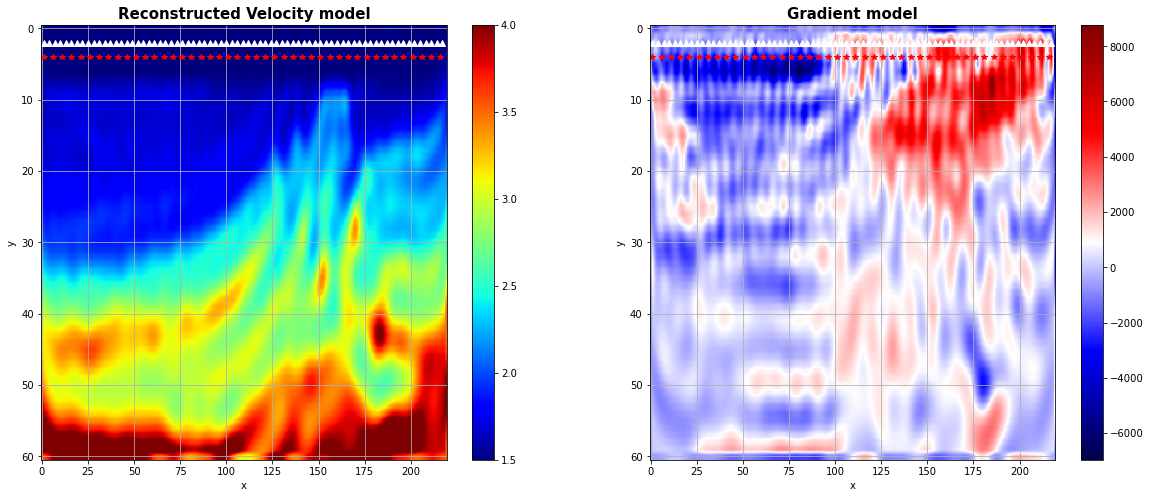

In [14]:
# plot model
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(1./np.sqrt(mk).reshape(n), vmin=1.5, vmax=4, cmap='jet')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reconstructed Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(gk.reshape(n), cmap='seismic')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight');

# Least-squares migration

In [69]:
# spatial axes
dx, dz = 2, 2
h = np.array([dz, dx]) # z, x
n = np.array(vel.shape) # z, x

z = np.arange(0, n[0]) * dz
x = np.arange(0, n[1]) * dx

# frequencies
f = np.array([20.0, 30.0])

# sources position
xs = np.arange(dx, n[1]*dx, 5 * dx)
zs = 4 * dx * np.ones_like(xs)

# receivers position
xr = np.arange(dx, n[1]*dx, 3 * dx)
zr = 2 * dx * np.ones_like(xr)

# sources matrix
q = np.eye(len(xs))

# perturbation
dm = m - m0

(-0.5, 219.5, 60.5, -0.5)

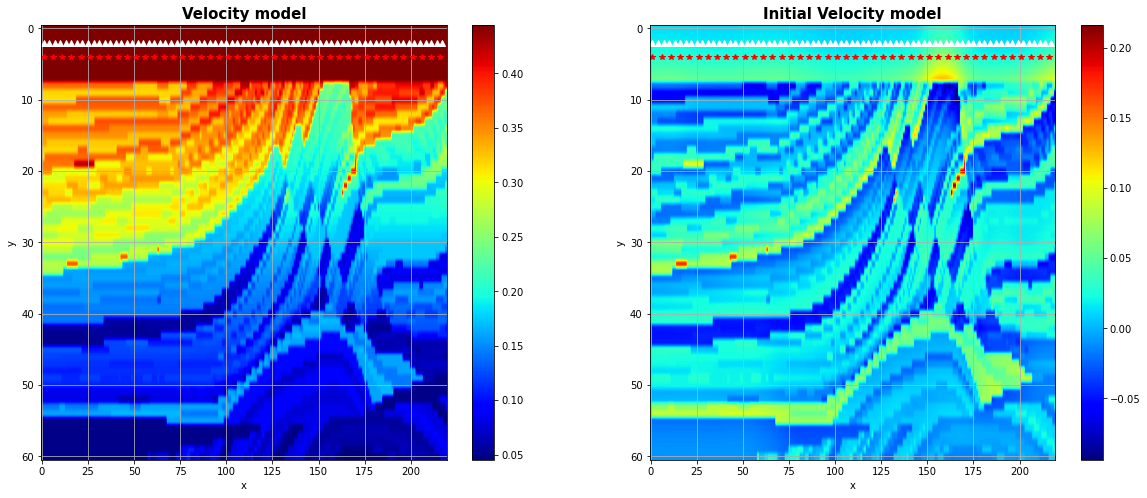

In [70]:
# plot model
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(m.reshape(n), cmap='jet')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(dm.reshape(n), cmap='jet')
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

In [71]:
model = {
    'h': h,
    'f': f,
    'xr': xr,
    'zr': zr,
    'xs': xs,
    'zs': zs,
    'n': n,
    'z': z,
    'x': x,
    'q': q,
}

Fm = ForwardSolver(model)
_, Jo = Fm.solve(m0)

dm = m - m0
Dlin = Jo * dm

madj = np.real(Jo.H @ Dlin)
minv = np.real(linalg.lsqr(Jo, Dlin, iter_lim=20, x0=np.zeros_like(m.ravel()).astype(np.complex), show=1)[0])

/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_r],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 6424 rows and 13420 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.894e+00  3.894e+00    1.0e+00  1.2e-01


/Users/ravasim/opt/anaconda3/envs/pylops/lib/python3.8/site-packages/scipy/sparse/linalg/isolve/lsqr.py:403: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])
/Users/ravasim/opt/anaconda3/envs/pylops/lib/python3.8/site-packages/scipy/sparse/linalg/isolve/lsqr.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


     1 -1.74970e-03   3.790e+00  3.790e+00    9.7e-01  2.5e-01   2.0e+00  1.0e+00
     2 -2.77894e-03   3.761e+00  3.761e+00    9.7e-01  1.1e-01   5.1e+00  3.6e+00
     3 -3.53997e-03   3.747e+00  3.747e+00    9.6e-01  6.2e-02   9.4e+00  8.0e+00
     4 -4.15486e-03   3.739e+00  3.739e+00    9.6e-01  4.2e-02   1.4e+01  1.4e+01
     5 -4.67592e-03   3.734e+00  3.734e+00    9.6e-01  3.1e-02   2.0e+01  2.2e+01
     6 -5.13089e-03   3.730e+00  3.730e+00    9.6e-01  2.4e-02   2.7e+01  3.2e+01
     7 -5.53639e-03   3.726e+00  3.726e+00    9.6e-01  1.9e-02   3.4e+01  4.4e+01
     8 -5.90328e-03   3.724e+00  3.724e+00    9.6e-01  1.6e-02   4.2e+01  5.8e+01
     9 -6.23907e-03   3.722e+00  3.722e+00    9.6e-01  1.4e-02   5.0e+01  7.3e+01
    10 -6.54920e-03   3.720e+00  3.720e+00    9.6e-01  1.2e-02   5.9e+01  9.1e+01
    11 -6.83773e-03   3.719e+00  3.719e+00    9.6e-01  1.0e-02   6.8e+01  1.1e+02
    12 -7.10782e-03   3.718e+00  3.718e+00    9.5e-01  9.3e-03   7.7e+01  1.3e+02
    13 -7.36193e

(-0.5, 219.5, 60.5, -0.5)

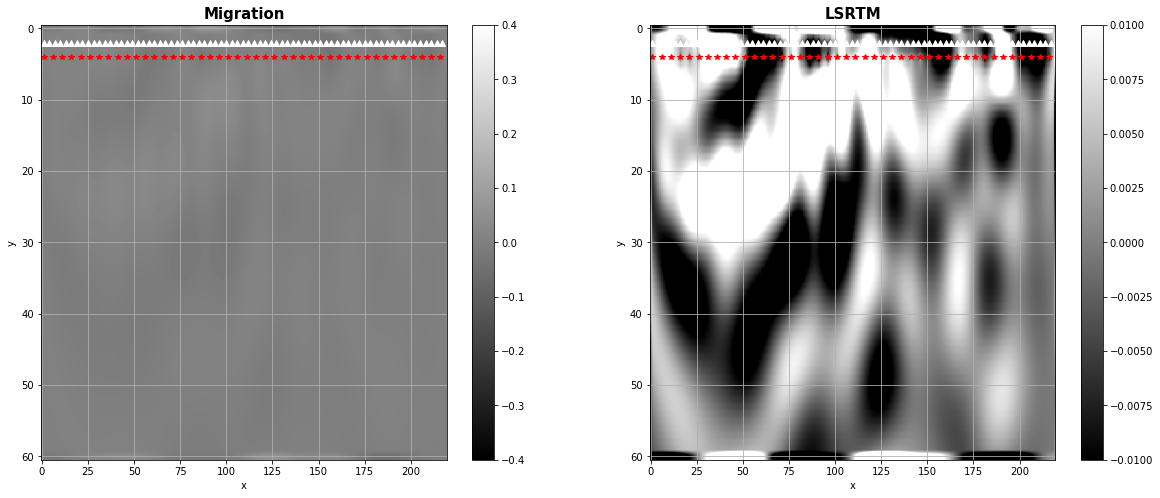

In [72]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(madj.reshape(n), cmap='gray', vmin=-4e-1, vmax=4e-1)
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Migration', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(minv.reshape(n), cmap='gray', vmin=-1e-2, vmax=1e-2)
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('LSRTM', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')